 ![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Fine Tuning Model: DreamBooth Inference

The following code is for the inference part of the DreamBooth model. The model training can be found in the notebook "DreamBooth.ipynb" in section 4. Fine Tuning Models. 

### Import Packages and Install Diffusion libraries

In [1]:
import os
import shutil

In [2]:
# Diffuser libraries 

!pip install -qq "ipywidgets>=7,<8"
!git clone https://github.com/huggingface/diffusers
!pip install ./diffusers

Cloning into 'diffusers'...
remote: Enumerating objects: 63600, done.
remote: Counting objects: 100% (14446/14446), done.
remote: Compressing objects: 100% (1338/1338), done.
remote: Total 63600 (delta 13843), reused 13295 (delta 13031), pack-reused 49154
Receiving objects: 100% (63600/63600), 44.85 MiB | 31.12 MiB/s, done.
Resolving deltas: 100% (46836/46836), done.
Processing ./diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.29.0.dev0-py3-none-any.whl size=2147359 sha256=f3e32b207fe4db76242ed9e6e04da92d7a326054e63338d96f35ed52b6e69b68
  Stored in directory: /tmp/pip-ephem-wheel-cache-t6cx00mg/wheels/f5/3d/4b/8e63ecf8f8467b91f49c2a926abe66393983fca5c47830e6e6
Successfully built diffusers


In [3]:
%cd /kaggle/working/diffusers/examples/dreambooth
!pip install -r requirements.txt
!pip install bitsandbytes
!pip install transformers gradio ftfy accelerate
!pip install xformers

/kaggle/working/diffusers/examples/dreambooth
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 89.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 94.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 8.6 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=5584 sha256=e9620f0504fbdc5dcde172fa10805f61985fb814b935777b8c97dbf97eae17c5
  Stored in directory:

In [4]:
# Model Training 
from diffusers import DiffusionPipeline, UNet2DConditionModel
from transformers import CLIPTextModel
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-05-29 09:46:16.809780: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 09:46:16.809876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 09:46:16.953823: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
!pip install huggingface_hub

Replace "TOKEN" with own personal Hugging Face token in order to save model in a private model and dataset. 

In [6]:
from huggingface_hub import login
login(token="TOKEN") 

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


For instructions on how to set up the secret token on Kaggle: https://github.com/maelysjb/Comics-GenAI/blob/main/README.md#:~:text=.gitignore-,README,-.md

In [7]:
from kaggle_secrets import UserSecretsClient
secret_label = "HUGGINGFACE_TOKEN"
secret_value = UserSecretsClient().get_secret(secret_label)

### Loading the trained model 

Replace the base model path with the desired Hugging Face repository

In [8]:
# Define the base Hugging Face repository path
base_model_path = 'nataliabeltran/DreamBooth2000' 

# Load UNet2DConditionModel from the specific subfolder
unet = UNet2DConditionModel.from_pretrained(base_model_path, subfolder='unet', torch_dtype=torch.float16)

# Load CLIPTextModel from the specific subfolder
text_encoder = CLIPTextModel.from_pretrained(base_model_path, subfolder='text_encoder', torch_dtype=torch.float16)

# pipeline 
pipeline = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", unet=unet,
    text_encoder=text_encoder, torch_dtype=torch.float16,
).to("cuda")

# Check models are loaded successfully
print("UNet2DConditionModel loaded successfully.")
print("CLIPTextModel loaded successfully.")



unet/config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

UNet2DConditionModel loaded successfully.
CLIPTextModel loaded successfully.


### Inference  function 

In [9]:
import IPython.display as display

def inference(prompt, num_samples, negative_prompt, guidance_scale,
              num_inference_steps, height, width):
    images = pipeline(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale
    ).images
    for i, image in enumerate(images):
        image.save(f"generated_image_{i}.png") 
        print(f"Generated image {i}:")
        display(image)  

### Display outputs from DreamBooth model
To generate different images of the character/data change the prompt ensuring to keep the same phrasing that was used while training. 

More images at different training steps for the different models can be found here: https://github.com/maelysjb/Comics-GenAI/tree/main/6.%20Generated%20Images

In [10]:
# Image Display
from IPython.display import display  
from PIL import Image
import matplotlib.pyplot as plt

  0%|          | 0/50 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Generated image 0:


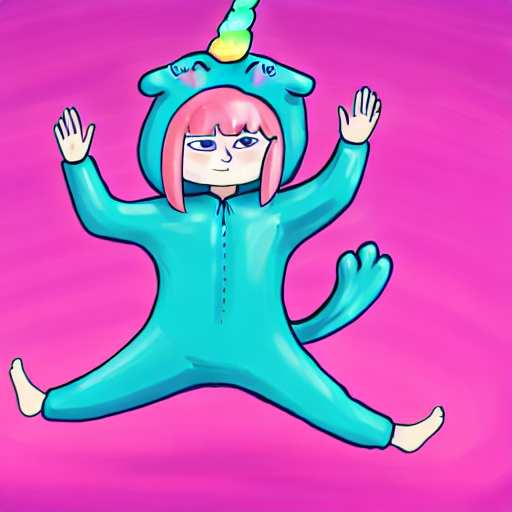

Generated image 1:


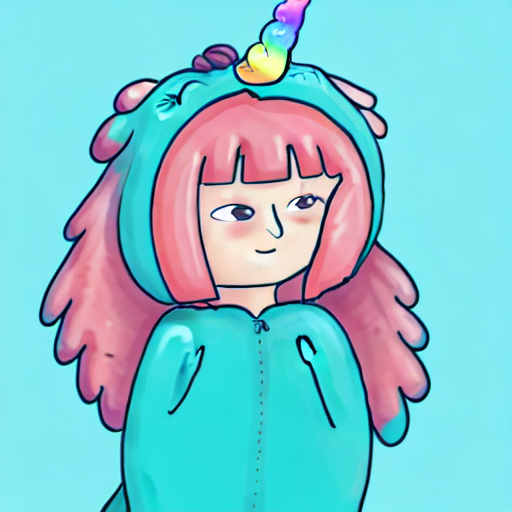

Generated image 2:


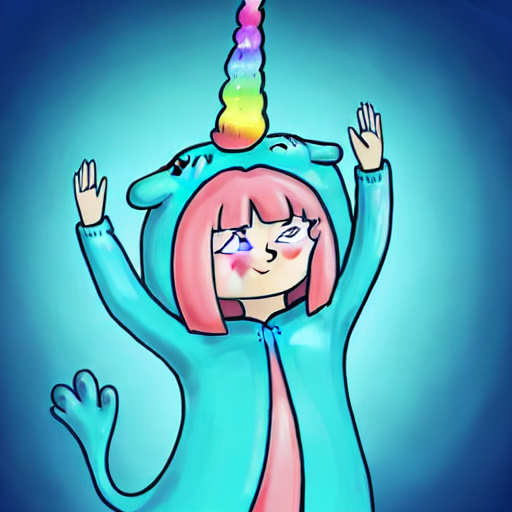

Generated image 3:


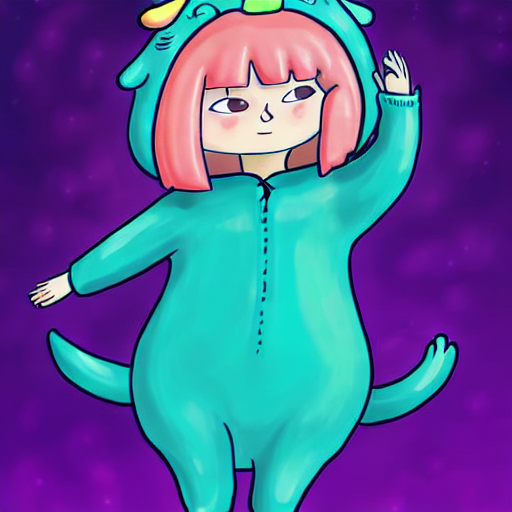

Generated image 4:


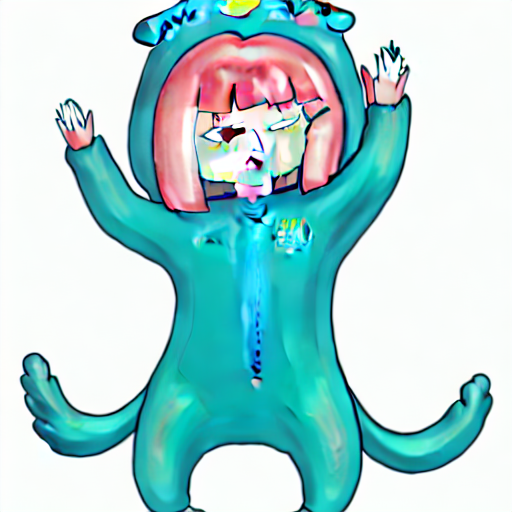

In [11]:
prompt = "An image of UnicornGirl in unicorn onesie with hands on face"
num_samples = 5
negative_prompt = ""
guidance_scale = 7.5
num_inference_steps = 50
height = 512
width = 512

inference(prompt, num_samples, negative_prompt, guidance_scale, num_inference_steps, height, width)